In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

Dataset loaded
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


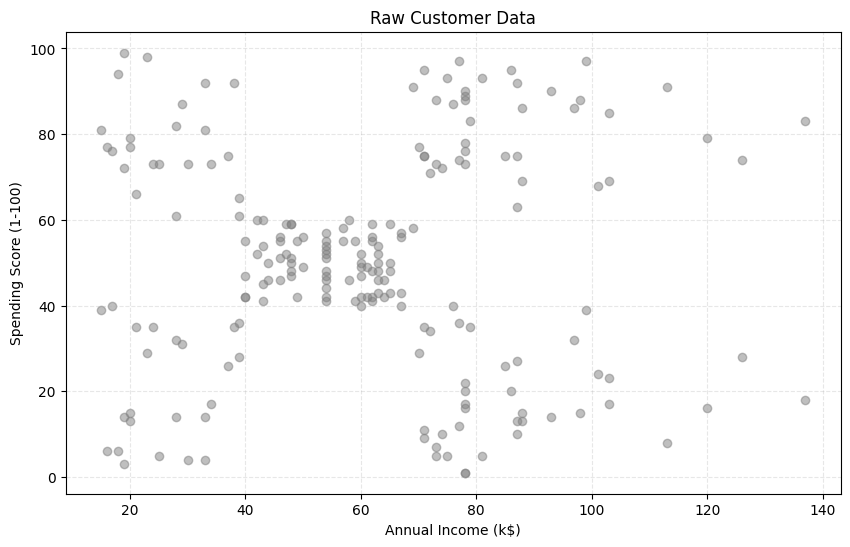

In [7]:
# Data acquisition & preprocessing

url = "https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/master/Datasets/Mall_Customers.csv"

try:
    df_full = pd.read_csv(url)
    print("Dataset loaded")
    print(df_full.head())
except Exception as e:
    print(f"Error loading data: {e}")
    # df_full = pd.read_csv('Mall_Customers.csv')

df = df_full[["Annual Income (k$)", "Spending Score (1-100)"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

plt.figure(figsize=(10, 6))
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"], c="grey", alpha=0.5)
plt.title("Raw Customer Data")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

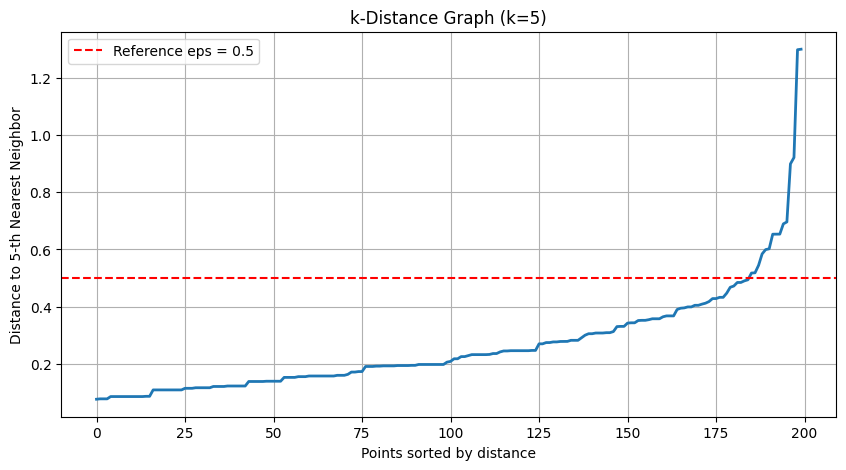

In [8]:
# Epsilon (eps) selection with k-distance graph

k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k - 1], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances, linewidth=2)
plt.title(f"k-Distance Graph (k={k})")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.axhline(y=0.5, color="r", linestyle="--", label="Reference eps = 0.5")
plt.legend()
plt.grid(True)
plt.show()

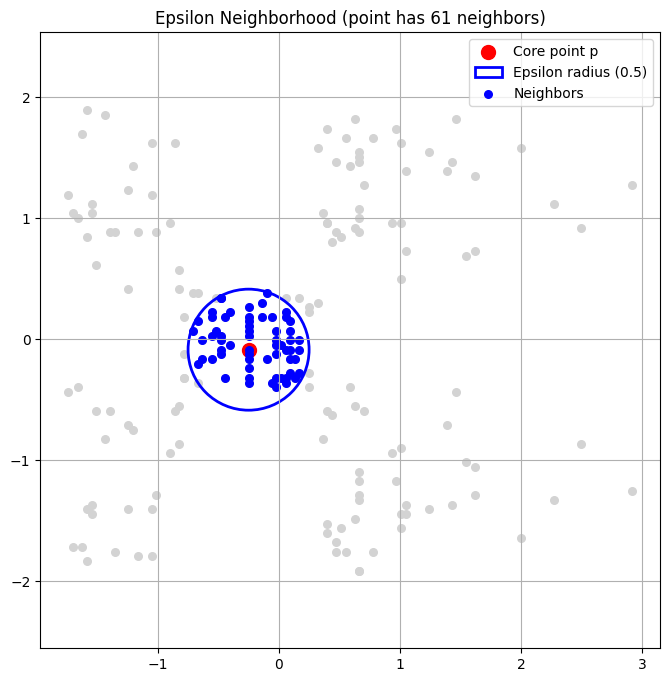

In [9]:
# Visualizing the epsilon neighborhood of a core point

db_demo = DBSCAN(eps=0.365, min_samples=5).fit(X_scaled)

radius_neighbors = NearestNeighbors(radius=0.5).fit(X_scaled)
distances_rad, indices_rad = radius_neighbors.radius_neighbors(X_scaled)
neighbor_counts = [len(x) for x in indices_rad]
best_core_idx = np.argmax(neighbor_counts)

target_point = X_scaled[best_core_idx]

plt.figure(figsize=(8, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c="lightgrey", s=30)

plt.scatter(target_point[0], target_point[1], c="red", s=100, label="Core point p")

circle = plt.Circle(
    (target_point[0], target_point[1]),
    0.5,
    color="blue",
    fill=False,
    linewidth=2,
    label="Epsilon radius (0.5)",
)
plt.gca().add_patch(circle)

distances_to_target = np.linalg.norm(X_scaled - target_point, axis=1)
neighbors_mask = distances_to_target < 0.5
plt.scatter(
    X_scaled[neighbors_mask, 0],
    X_scaled[neighbors_mask, 1],
    c="blue",
    s=30,
    label="Neighbors",
)

plt.title(
    f"Epsilon Neighborhood (point has {len(X_scaled[neighbors_mask]) - 1} neighbors)"
)
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

Results:
Clusters found: 5
Noise points (outliers): 21
Noise ratio: 10.50%


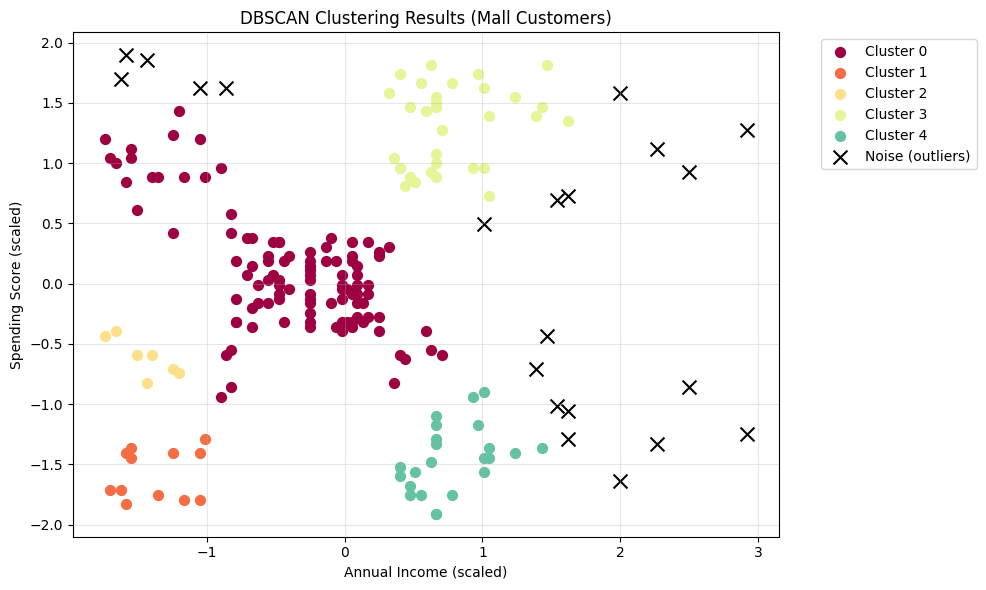

In [10]:
# Final DBSCAN run and evaluation

db_final = DBSCAN(eps=0.365, min_samples=5).fit(X_scaled)
labels = db_final.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
noise_ratio = n_noise / len(labels)

print("Results:")
print(f"Clusters found: {n_clusters}")
print(f"Noise points (outliers): {n_noise}")
print(f"Noise ratio: {noise_ratio:.2%}")

plt.figure(figsize=(10, 6))

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k_label, col in zip(unique_labels, colors):
    if k_label == -1:
        col = [0, 0, 0, 1]
        label_text = "Noise (outliers)"
        marker_shape = "x"
        size = 100
    else:
        label_text = f"Cluster {k_label}"
        marker_shape = "o"
        size = 50

        # nothing special, same col

    class_member_mask = labels == k_label
    xy = X_scaled[class_member_mask]
    plt.scatter(
        xy[:, 0], xy[:, 1], c=[col], marker=marker_shape, s=size, label=label_text
    )

plt.title("DBSCAN Clustering Results (Mall Customers)")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()